In [160]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imprint as ip
import imprint.bound.normal as normal
from imprint.models.ztest import ZTest1D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
def tie(theta, thresh):
    return scipy.stats.norm.sf(thresh-theta)

In [162]:
theta_min = -1
theta_max = 0
alpha = 0.025
n_sims = 1000

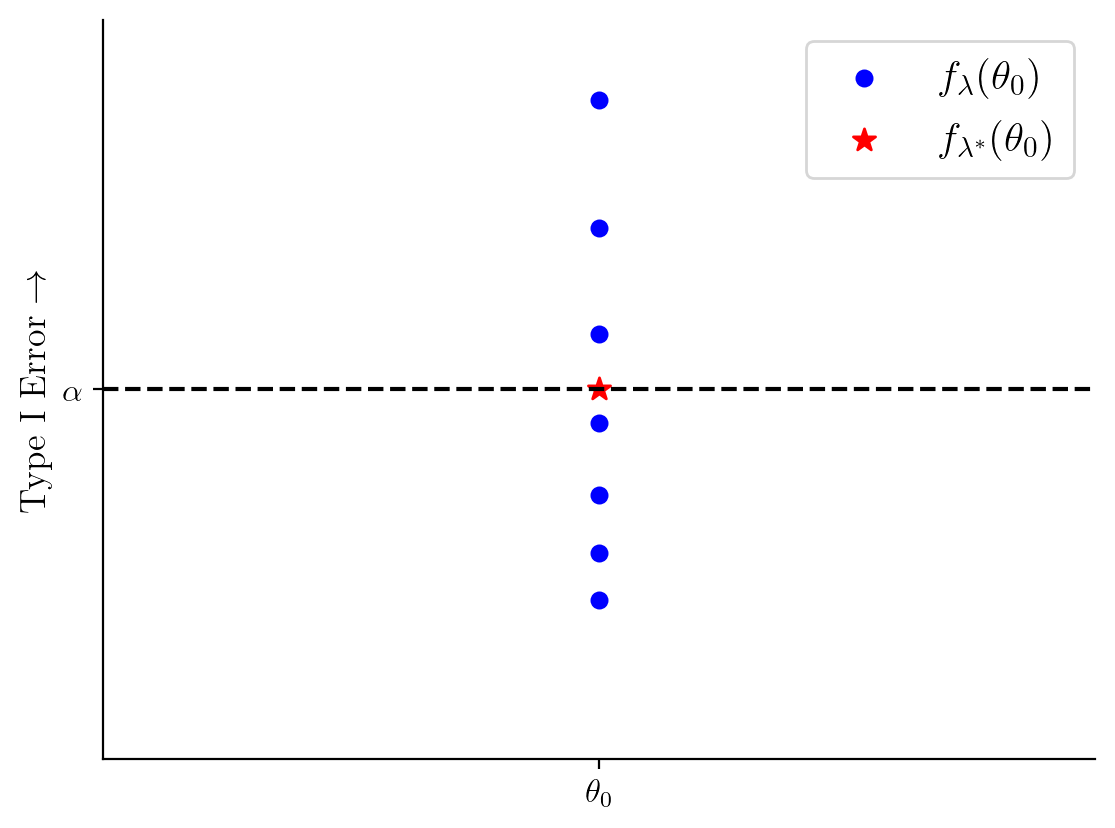

In [164]:
theta0 = -0.5
ts = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8])
ties = tie(theta0, ts)

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
ax.scatter(np.full(len(ties), theta0), ties, s=30, color='b', label='$f_{\lambda}(\\theta_0)$')
ax.scatter(theta0, alpha, s=70, color='r', marker='*', label='$f_{\lambda^*}(\\theta_0)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.set_ylabel('Type I Error $\\rightarrow$')
ax.axes.set_xticks([theta0], labels=['$\\theta_0$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta0+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
plt.legend()
plt.savefig('figures/calibration_point_null.pdf', bbox_inches='tight')
plt.show()

In [148]:
def calib_tie(theta0, n_sims, alpha):
    k = int((n_sims + 1) * alpha)
    return k / (n_sims + 1)

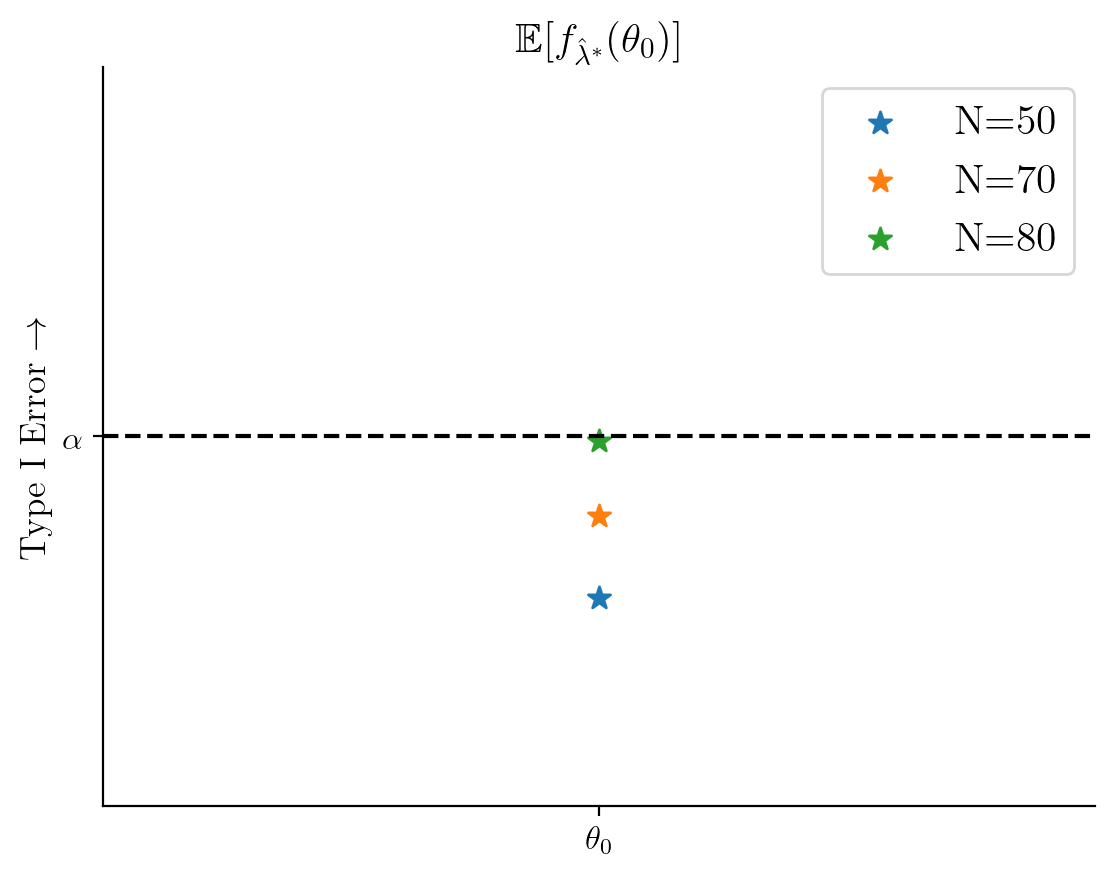

In [169]:
n_sims_list = np.array([50, 70, 80])
calib_ties = np.array([calib_tie(theta0, n, alpha) for n in n_sims_list])
calib_ties = np.sort(calib_ties) # just for visuals

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
for n_sim, tie in zip(n_sims_list, calib_ties):
    ax.scatter(theta0, tie, 
        s=70, marker='*',
        label=f"N={n_sim}",
    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Type I Error $\\rightarrow$')
ax.axes.set_xticks([theta0], labels=['$\\theta_0$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta0+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
ax.set_title('$\mathbb{E}[f_{\hat{{\lambda}}^*}(\\theta_0)]$')
plt.legend()
plt.savefig('figures/calibration_point_null_solution.pdf', bbox_inches='tight')
plt.show()

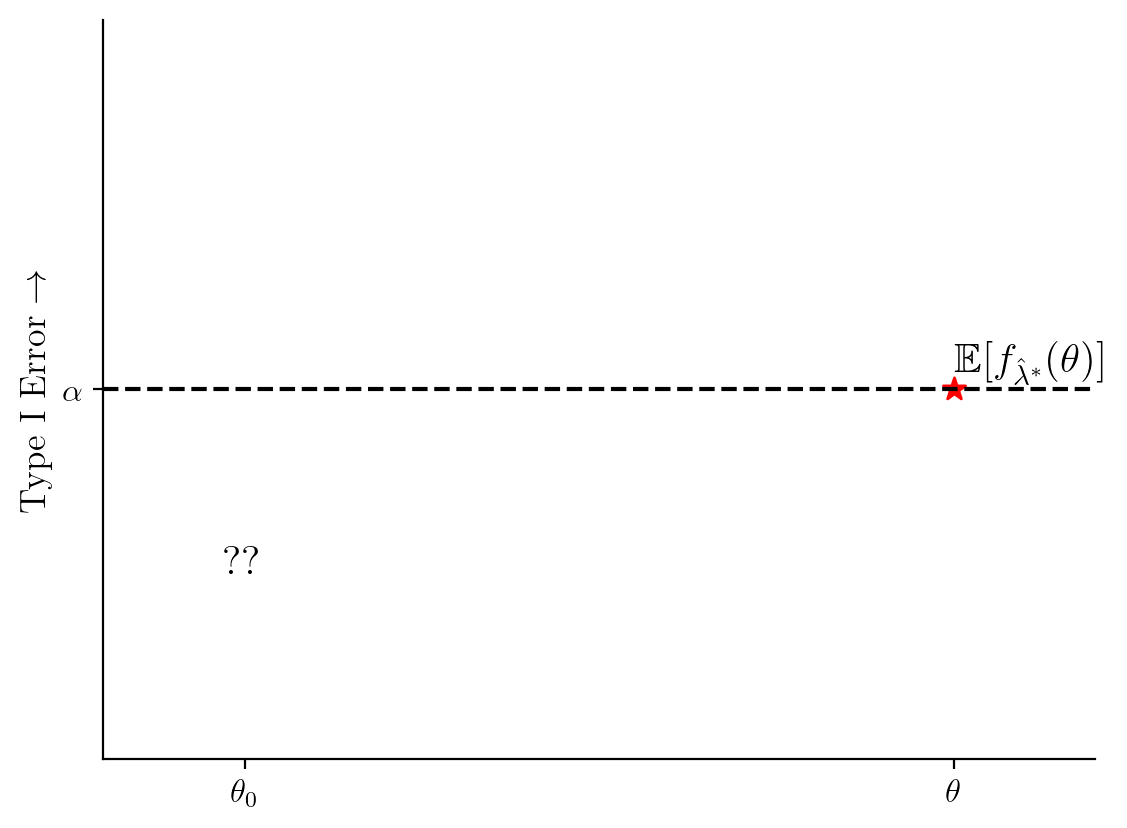

In [167]:
theta = theta_max

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
ax.scatter(theta, alpha, s=70, marker='*', color='r')
ax.annotate("??", (theta0-1.5e-2, alpha / 2))
ax.annotate("$\mathbb{E}[f_{\hat{{\lambda}}^*}(\\theta)]$", (theta, alpha * 1.05))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Type I Error $\\rightarrow$')
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
plt.savefig('figures/calibration_tile.pdf', bbox_inches='tight')
plt.show()

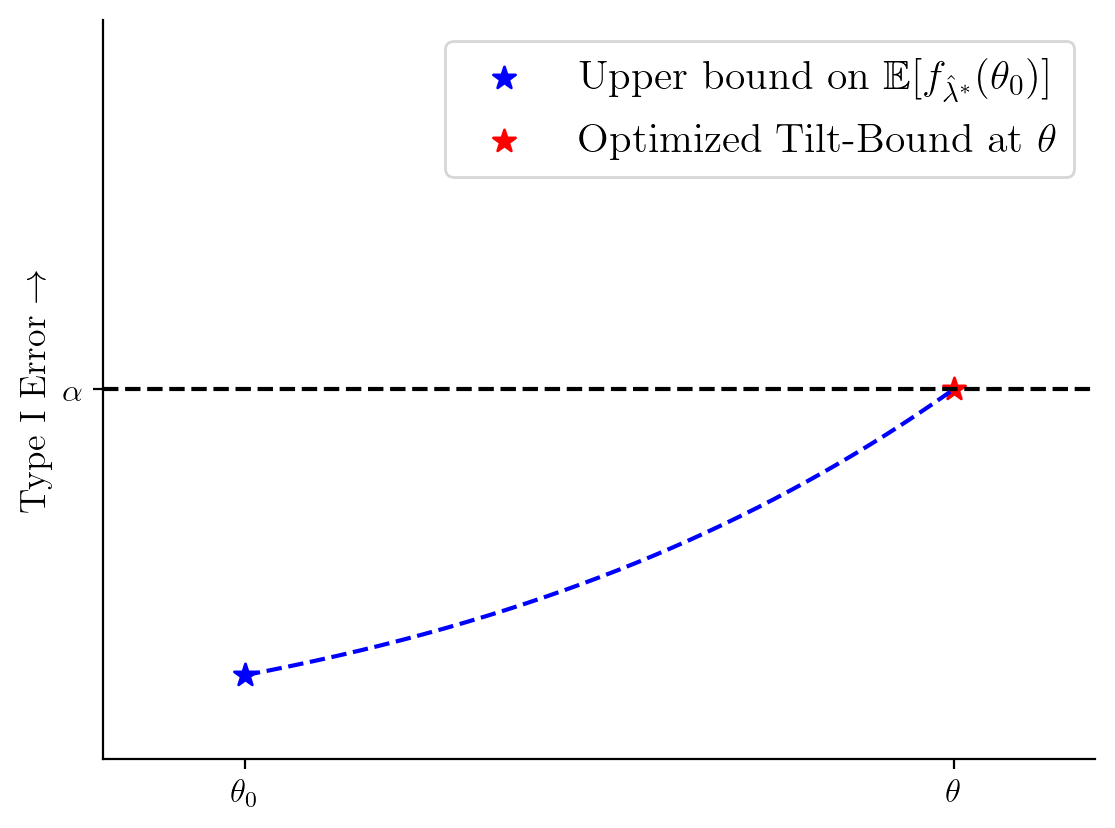

In [168]:
bwd_solver = normal.BackwardQCPSolver(1)
v = theta-theta0
q = bwd_solver.solve(v, alpha)
bound = normal.tilt_bound_bwd_tile(q, 1, v, alpha)

vs = jnp.linspace(0, theta-theta0, 1000)
fwd_solver = normal.ForwardQCPSolver(1)
fwd_qs = jax.vmap(fwd_solver.solve, in_axes=(0, None))(vs, bound)
fwd_bounds = jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None))(fwd_qs, 1, vs, bound)

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
ax.scatter(theta0, bound, s=70, marker='*', color='b', 
    label='Upper bound on $\mathbb{E}[f_{\hat{{\lambda}}^*}(\\theta_0)$]',
)
ax.scatter(theta, alpha, s=70, marker='*', color='r', 
    label='Optimized Tilt-Bound at $\\theta$',
)
ax.plot(theta0 + vs, fwd_bounds, linestyle='--', color='b')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Type I Error $\\rightarrow$')
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
plt.legend()
plt.savefig('figures/calibration_tile_solution.pdf', bbox_inches='tight')
plt.show()

In [123]:
def beta_integrated_TIE(npt, nsims, alpha=0.025):
    radius = 0.5 / npt
    qback = normal.BackwardQCPSolver(scale=1)
    qback = qback.solve(radius, alpha)
    optboundback = normal.tilt_bound_bwd(qback, 1, radius, alpha)
    orderstat = int(optboundback * (nsims + 1))
    betaparams = (orderstat, nsims + 1 - orderstat)
    return scipy.stats.beta.expect(
        lambda x: scipy.stats.norm.cdf(-radius + scipy.stats.norm.ppf(x)),
        betaparams,
    )

def vectorize_over_nsim(npt, nsims, alpha):
    return np.array([beta_integrated_TIE(npt, nsim, alpha) for nsim in nsims])


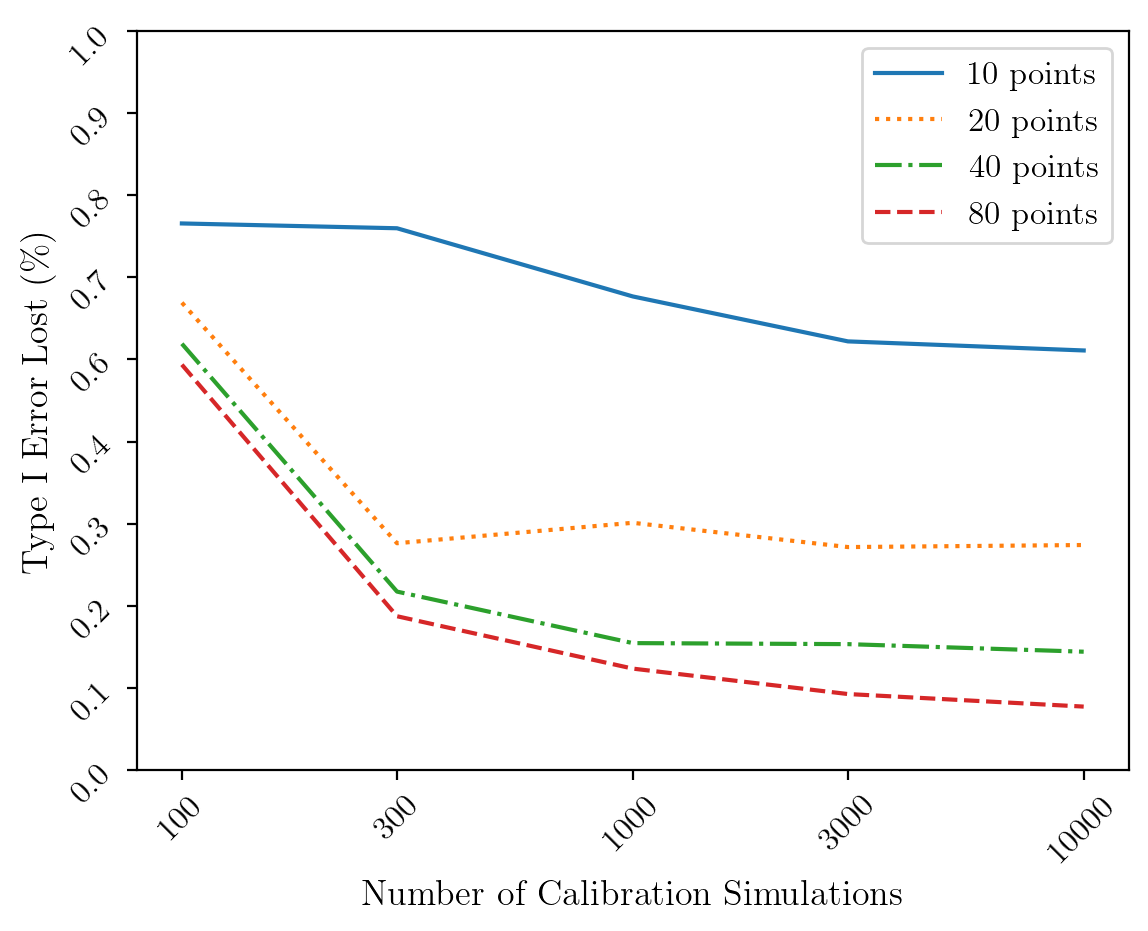

In [127]:
styles = ["-", ":", "-.", "--"]
npts = np.array([10, 20, 40, 80])
nsims = np.array([100, 300, 1000, 3000, 10000])

for i in range(len(npts)):
    temp = vectorize_over_nsim(npts[i], nsims, alpha)
    plt.plot(np.log(nsims), alpha - temp, linestyle=styles[i], label=f"{npts[i]:.0f} points")

plt.legend(fontsize=12)
plt.ylabel("Type I Error Lost (\%)")
yticks = np.linspace(0, 0.01, 10)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.01f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xticks(np.log(nsims), rotation=45)
plt.gca().set_xticklabels(nsims)
plt.xlabel("Number of Calibration Simulations")
plt.savefig("figures/z-test-cost.pdf", bbox_inches="tight")
plt.show()

In [173]:
def calib_full_tie(thetas, n_tiles, n_sim, seed=0, theta_min=theta_min, theta_max=theta_max, alpha=alpha):
    key = jax.random.PRNGKey(seed)
    norms = jax.random.normal(key, (n_sim,))
    bwd_solver = normal.BackwardQCPSolver(1)

    def _tie(t, max_theta, k):
        return scipy.stats.beta.expect(
            lambda x: scipy.stats.norm.cdf(
                scipy.stats.norm.ppf(x) + 
                + t - max_theta 
            ),
            (k, n_sim+1-k),
        ) 
        
    _vtie = np.vectorize(_tie)

    out = []
    for n_tile in n_tiles:
        grid = ip.cartesian_grid([theta_min], [theta_max], n=[n_tile], null_hypos=[ip.hypo("x <= 0")])
        theta = grid.get_theta()[:, 0]
        radius = grid.get_radii()[0, 0]
        q_prime = bwd_solver.solve(radius, alpha)
        alpha_prime = normal.tilt_bound_bwd_tile(q_prime, 1, radius, alpha)
        k = int((n_sim + 1) * alpha_prime)
        max_theta = np.max(theta)

        out.append(_vtie(thetas, max_theta, k))
        
    return np.array(out)


In [214]:
thetas = np.linspace(theta_min, theta_max, 100)
n_tiles = [2, 4, 10, 64]
N_large = 1000
ties_N = calib_full_tie(thetas, n_tiles, N_large)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=2, worker_id=1, t=1675453081, n_bits=18, worker_bits=18) = [4455794579781976064 4455794579781976065, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=4, worker_id=1, t=1675453085, n_bits=18, worker_bits=18) = [4455794854659883008 4455794854659883009 4455794854659883010, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=10, worker_id=1, t=1675453090, n_bits=18, worker_bits=18) = [4455795198257266688 4455795198257266689 4455795198257266690, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=64, worker_id=1, t=1675453095, n_bits=18, worker_bits=18) = [4455795541854650368 4455795541854650369 4455795541854650370, ...]:


In [215]:
n_sims = [50, 70, 100, 1000]
I_large = 64
ties_I = np.array([calib_full_tie(thetas, [I_large], n_sim)[0] for n_sim in n_sims])

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=64, worker_id=1, t=1675453099, n_bits=18, worker_bits=18) = [4455795816732557312 4455795816732557313 4455795816732557314, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=64, worker_id=1, t=1675453102, n_bits=18, worker_bits=18) = [4455796022890987520 4455796022890987521 4455796022890987522, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=64, worker_id=1, t=1675453104, n_bits=18, worker_bits=18) = [4455796160329940992 4455796160329940993 4455796160329940994, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=64, worker_id=1, t=1675453107, n_bits=18, worker_bits=18) = [4455796366488371200 4455796366488371201 4455796366488371202, ...]:


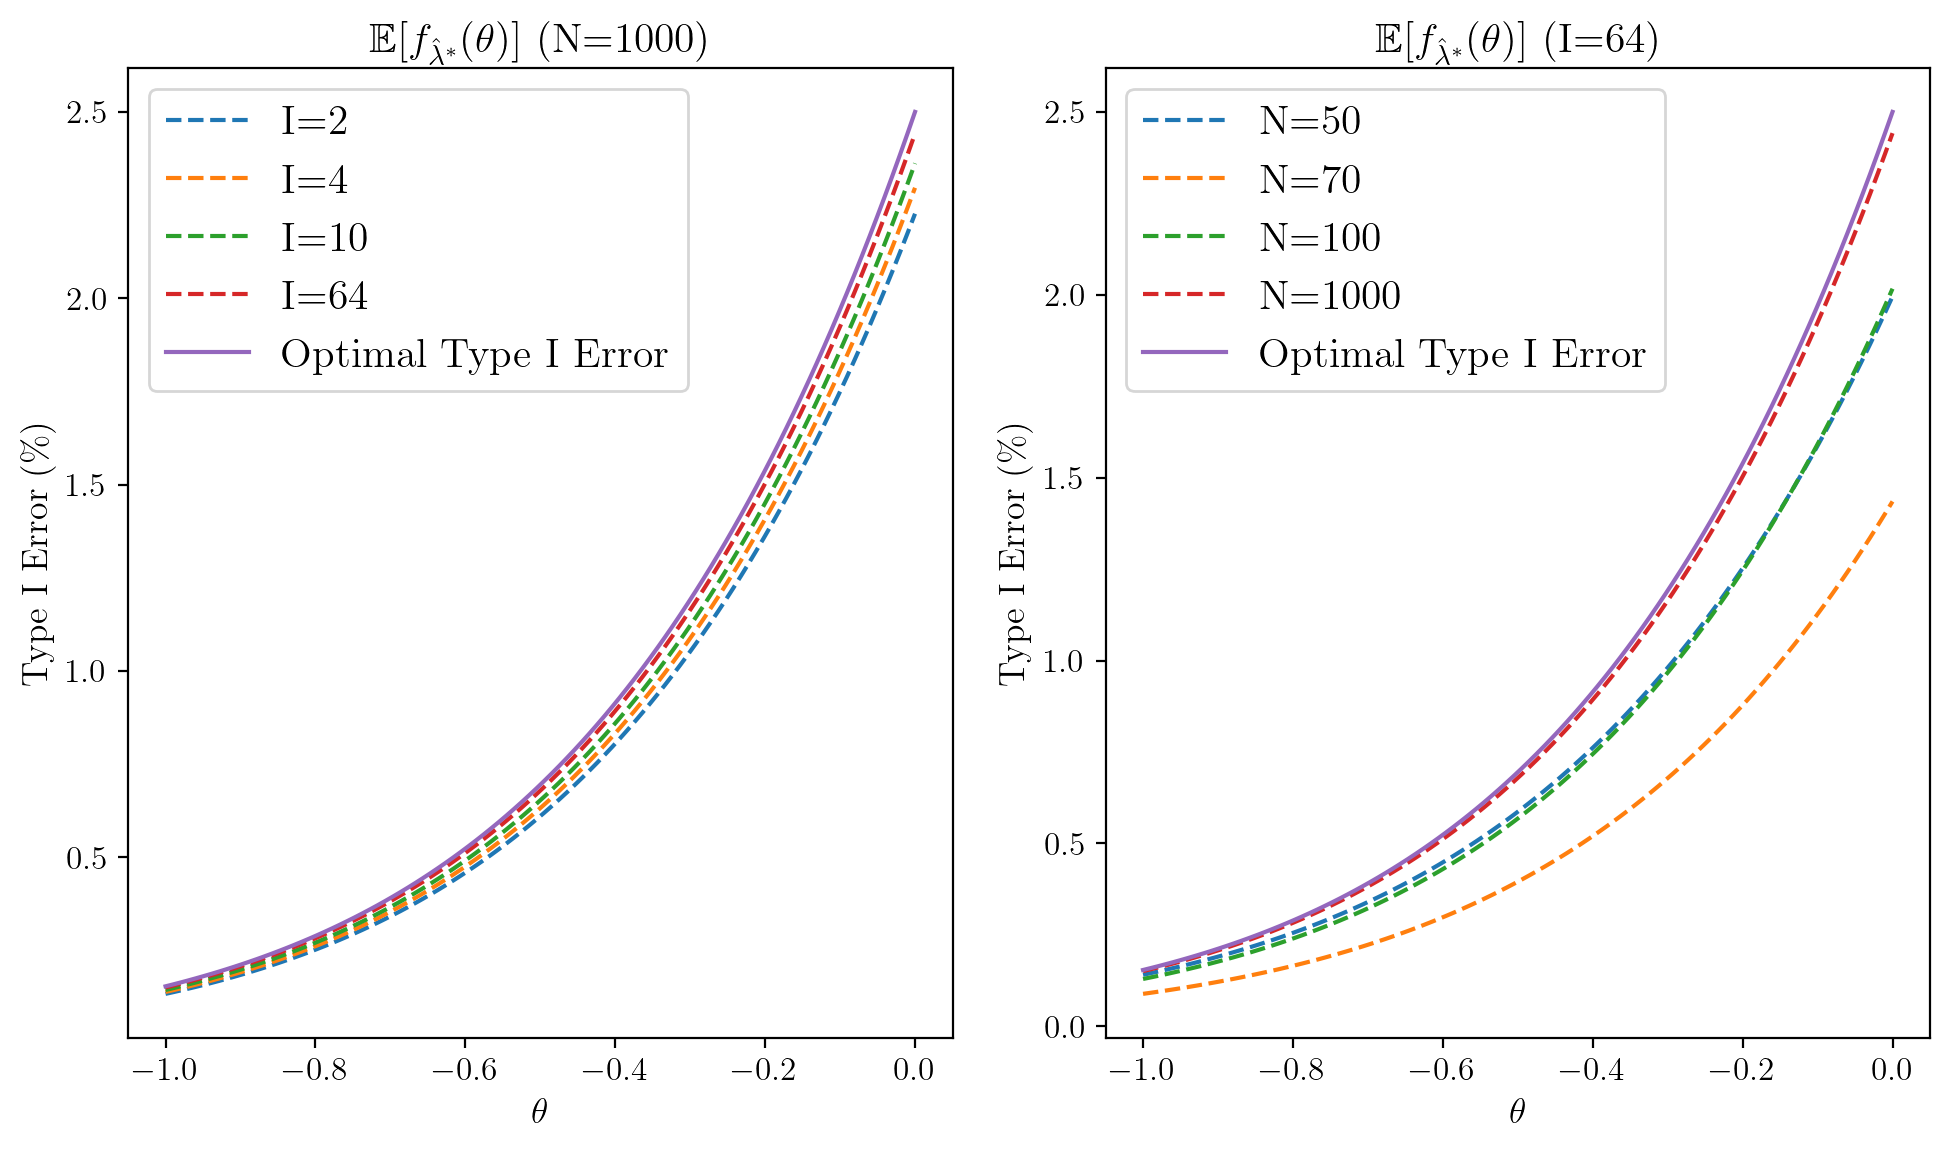

In [237]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

for i, n_tile in enumerate(n_tiles):
    tie_i = ties_N[i]
    axes[0].plot(thetas, tie_i*100, linestyle='--', label=f"I={n_tile}")

for i, n_sim in enumerate(n_sims):
    tie_i = ties_I[i]
    axes[1].plot(thetas, tie_i*100, linestyle='--', label=f"N={n_sim}")

z_crit = scipy.stats.norm.isf(alpha)
true_ties = tie(thetas, z_crit)

for i in range(2):
    axes[i].plot(thetas, true_ties*100, linestyle='-', label="Optimal Type I Error")
    if i == 0:
        title = f"$\mathbb{{E}}[f_{{\hat{{\lambda}}^*}}(\\theta)]$ (N={N_large})"
    else:
        title = f"$\mathbb{{E}}[f_{{\hat{{\lambda}}^*}}(\\theta)]$ (I={I_large})"
    axes[i].set_title(title)
    axes[i].legend()
    axes[i].set_xlabel('$\\theta$')
    axes[i].set_ylabel('Type I Error (\%)')
plt.tight_layout()
plt.savefig('figures/calibration_z_test.pdf', bbox_inches='tight')
plt.show()